# 0. Imports

In [78]:
# 1. Data Load
import numpy as np
import pandas as pd
from pathlib import Path

# 2. Pré-processamento
import re
import unicodedata
from tqdm import tqdm

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

# 3. Feature Extraction
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer

# 4. Dimension Reduction
import umap.umap_ as umap
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

#5. KMeans
from sklearn.cluster import KMeans
from sklearn.cluster import HDBSCAN
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\EsdrasDaniel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\EsdrasDaniel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\EsdrasDaniel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\EsdrasDaniel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# 1. Data Load

In [79]:
path = Path('./data/pgm-dataset-new.parquet')
df_teste = pd.read_parquet(path)

print(f'Shape: {df_teste.shape}')
df_teste.head(3)

Shape: (15347, 10)


,intimacao_conteudo,processo_conteudo,rstREGEX,teorIntimacao,intimacaoPJE,processoPJE,idavisopje,setordestino,Classificacao,general_classes
0,,,"[{""diligencia"": ""intime-se o Município de Nata...",PODER JUDICIÁRIO ESTADO DO RIO GRANDE DO NORTE...,"{""id"": ""18612632"", ""tipoComunicacao"": ""INT"", ""...","{""Numero"": ""08387198120248205001"", ""Competenci...",18612632,Procuradoria da Saude,,Saude
1,,,"[{""diligencia"": ""intimado acerca da obrigação ...",PODER JUDICIÁRIO DO ESTADO DO RIO GRANDE DO NO...,"{""id"": ""18629258"", ""tipoComunicacao"": ""INT"", ""...","{""Numero"": ""08464942120228205001"", ""Competenci...",18629258,Procuradoria Administrativa,,Administrativa
3,,,"[{""diligencia"": ""intime-se a parte exequente p...",PODER JUDICIÁRIO DO ESTADO DO RIO GRANDE DO NO...,"{""id"": ""18629665"", ""tipoComunicacao"": ""INT"", ""...","{""Numero"": ""01263147320118200001"", ""Competenci...",18629665,APOIO FISCAL,,Fiscal


In [80]:
path = Path('./data/pgm-dataset-new.parquet')
df = pd.read_parquet(path)

print(f'Shape: {df.shape}')
df.head(3)

Shape: (15347, 10)


,intimacao_conteudo,processo_conteudo,rstREGEX,teorIntimacao,intimacaoPJE,processoPJE,idavisopje,setordestino,Classificacao,general_classes
0,,,"[{""diligencia"": ""intime-se o Município de Nata...",PODER JUDICIÁRIO ESTADO DO RIO GRANDE DO NORTE...,"{""id"": ""18612632"", ""tipoComunicacao"": ""INT"", ""...","{""Numero"": ""08387198120248205001"", ""Competenci...",18612632,Procuradoria da Saude,,Saude
1,,,"[{""diligencia"": ""intimado acerca da obrigação ...",PODER JUDICIÁRIO DO ESTADO DO RIO GRANDE DO NO...,"{""id"": ""18629258"", ""tipoComunicacao"": ""INT"", ""...","{""Numero"": ""08464942120228205001"", ""Competenci...",18629258,Procuradoria Administrativa,,Administrativa
3,,,"[{""diligencia"": ""intime-se a parte exequente p...",PODER JUDICIÁRIO DO ESTADO DO RIO GRANDE DO NO...,"{""id"": ""18629665"", ""tipoComunicacao"": ""INT"", ""...","{""Numero"": ""01263147320118200001"", ""Competenci...",18629665,APOIO FISCAL,,Fiscal


## 1.1 - Removendo NaNs

In [81]:
# Vendo quantos são nulos em 'teorIntimacao'

df['teorIntimacao'].isna().value_counts()

teorIntimacao
False    15347
Name: count, dtype: int64

In [82]:
df.dropna(subset=['teorIntimacao'], axis=0, inplace=True)

print(f'Shape: {df.shape}')

Shape: (15347, 10)


# 2. Pré-processamento

## 2.1 - Funções

In [83]:
def normalizar_texto(texto: str, formatacao: str = 'NFD', remover_especiais=True):
    """
    Função para normalizar texto, removendo acentos e caracteres especiais.
    Parâmetros:
    texto: str - texto a ser normalizado
    formatacao: str - formatação a ser utilizada para normalização. Padrão: NFD
    Retorna:
    str - texto normalizado
    Exemplo:
    string_text = 'áéíóúçãõ ção -- __ ¬ ²³£¢¬9)( " ///°°?<>) jisadsa !// 1234 /*-+,&%$#@!'
    for form in ['NFC', 'NFKC', 'NFD', 'NFKD']:
        print(normalizar_texto(string_text, form))
    """

    # check valid formatacao
    if formatacao not in ['NFC', 'NFKC', 'NFD', 'NFKD']:
        raise ValueError('formatacao must be one of: NFC, NFKC, NFD, NFKD')

    if texto:
        # convert texto to str if not
        if type(texto) is not str:
            texto = str(texto)
        nfkd = unicodedata.normalize(formatacao, texto)  # NFKD
        palavra_sem_acento = u"".join([c for c in nfkd if not unicodedata.combining(c)])
        if remover_especiais is True:
            palavra_sem_acento = re.sub('[^a-zA-Z0-9 \\\]', '', palavra_sem_acento)

        return palavra_sem_acento.replace('  ', ' ')

    return texto

def preprocess_text_safe(text, with_space=True):
    """
    Realiza o pré-processamento de um texto, ignorando erros.

    Parâmetros:
        - text (str): Texto judicial a ser processado.

    Retorna:
        - Texto limpo e lematizado (str), ou uma string vazia se ocorrer um erro.
    """

    erros = []

    try:

        strange_words = [
            'assim',
            'parte',
            'rozana',
            'ato',
            'grande',
            'juiz djanirito souza moura',
            'cidade',
            'estado rio grande norte',
            'rio norte',
            'assinado',
            '36738671',
            'normal',
            'cod',
            'juiz',
            'ptbr',
            'lei',
            'praca sete setembro',
            'auto',
            'forma',
            'secretaria',
            'cidade alta',
            'data',
            'tributaria natal',
            'nao',
            '5902530',
            '59025275',
            'alta',
            'email',
            'rn',
            'publico',
            'valor',
            'intimese',
            'setembro',
            'norte',
            'whatsapp',
            'digitalmente',
            '2024',
            'natalrn',
            'judiciario',
            'secuniefttj',
            '59025300',
            'comarca',
            'obrig',
            'termos',
            'apos',
            '1141906',
            'estado',
            'processo',
            'rel',
            'forum fazendario',
            'forum',
            'fazendario',
            'norte',
            'telefone',
            'vara',
            'documento',
            'n1141906',
            'caso',
            'publica',
            'poder judiciario',
            'poder',
            'silva',
            'xnone',
            'prazo',
            'justica',
            'juiz djanirito souza mouro',
            'igo',
            'ate',
            'data registrada sistema',
            'sobre',
            'false',
            'sistema',
            'codigo',
            'dia',
            'direito',
            'cpc',
            'veft',
            'jusbr',
            'desde',
            'civil',
            'vara execucao fiscal',
            'juiza',
            'valores',
            'art',
            'cep',
            'conforme',
            'natal',
            'natalpraca',
            'forma lei',
            'tributaria',
            'rio',
            'praca alto',
            'acao',
            'municipio',
            'sete',
            'voltem',
            'conclusos',
            'publiquese',
            'cumprase',
            'artigo',
            'bem',
            'presente',
            'devera',
            'sendo',
            'ano',
            'inciso',
            'maria',
            'disposto',
            'ainda',
            'federal',
            'turma',
            'feito',
            'meio',
            'intimemse',
            'partir',
            'sob',
            'dje',
            'junho',
            'intimo',
            'julho',
            'manifestarse',
            'chefe',
            '59025300contato',
            '203'
        ]

        # Inicializar lematizador e stopwords
        lemmatizer = WordNetLemmatizer()
        stop_words = set(stopwords.words('portuguese'))

        text = normalizar_texto(text, 'NFD', remover_especiais=True)

        # Tokenizar texto
        tokens = word_tokenize(text)
        # Remover stopwords e lematizar tokens
        tokens = [
            lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and len(token) > 2
        ]

        # Reconstruir o texto processado
        processed_text = " ".join(tokens)

        # Remover strange_words com Regex
        pattern_re = "|".join(strange_words)

        processed_text = re.sub(
           f"\\b({pattern_re})\\b", "", processed_text, flags=re.IGNORECASE
        )

        # remover espacos duplos
        processed_text = " ".join(re.split(r"\s+", processed_text))
        if with_space is False:
            processed_text = processed_text.replace(" ", "")

        return processed_text

    except Exception as e:
        erro = str(e)
        if erro not in erros:
            erros.append(erro)
            print(f"Erro ao processar texto: {erro}")
            return ""  # Retorna texto vazio em caso de erro

## 2.2 - Limpeza

In [84]:
tqdm.pandas()

df['teorIntimacao_clean'] = df['teorIntimacao'].progress_apply(preprocess_text_safe)

100%|██████████| 15347/15347 [01:16<00:00, 200.23it/s]


# 3. Feature Extraction

## 3.1 - TFIDF

In [85]:
vectorizer = TfidfVectorizer(min_df=3, max_df=0.9, max_features=5000, ngram_range=(1,4))

X = vectorizer.fit_transform(df['teorIntimacao_clean'])
print(f'Shape: {X.shape}')

Shape: (15347, 5000)


## 3.2 - BERT

In [86]:
bert_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

embeddings = bert_model.encode(df['teorIntimacao_clean'].to_list(), show_progress_bar=True)

Batches: 100%|██████████| 480/480 [10:05<00:00,  1.26s/it]


# 4. Redução de Dimensionalidade

In [87]:
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, metric='cosine', random_state=42)

X_tfidf_2d = reducer.fit_transform(X)
X_emb_2d = reducer.fit_transform(embeddings)

c:\Users\EsdrasDaniel\Documents\Python\PGM-DataAnalysis\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\EsdrasDaniel\Documents\Python\PGM-DataAnalysis\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\EsdrasDaniel\Documents\Python\PGM-DataAnalysis\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


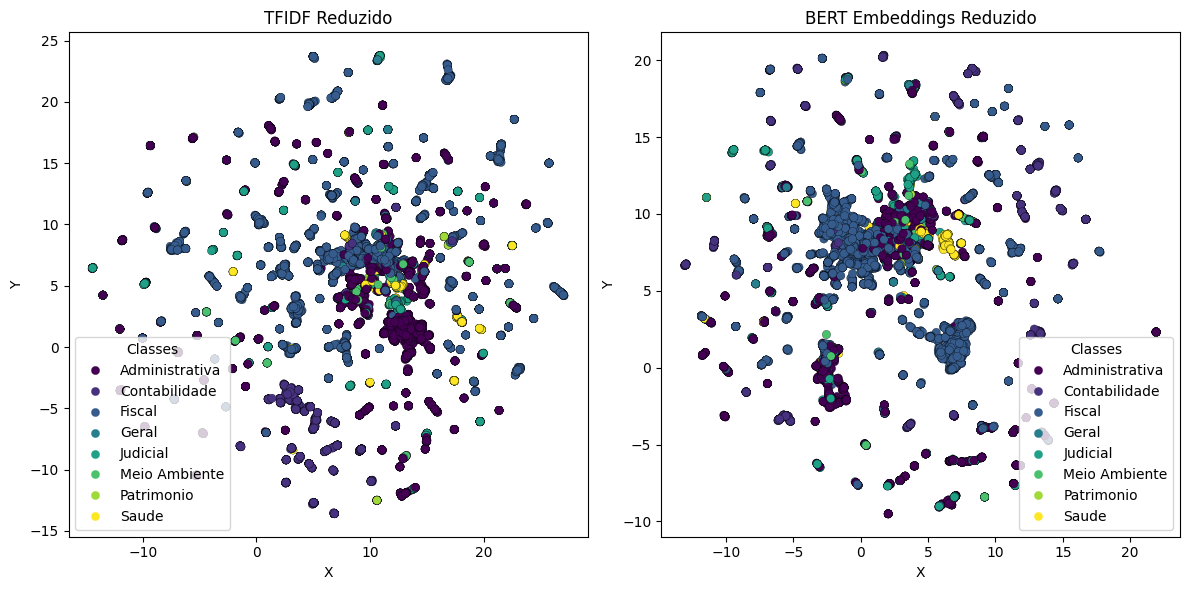

In [88]:
def plot_reduction(data1, data2, labels, title1="Plot 1", title2="Plot 2"):
    # Converte as labels para valores numéricos
    le = LabelEncoder()
    colors = le.fit_transform(labels)
    unique_labels = le.classes_.tolist()

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Primeiro subplot
    scatter1 = axes[0].scatter(data1[:, 0], data1[:, 1], linewidths=0.2, edgecolors='black', c=colors, cmap='viridis', label=unique_labels)
    axes[0].set_title(title1)
    axes[0].set_xlabel("X")
    axes[0].set_ylabel("Y")
    axes[0].legend(handles=scatter1.legend_elements()[0], labels=unique_labels, title="Classes")

    # Segundo subplot
    scatter2 = axes[1].scatter(data2[:, 0], data2[:, 1], linewidths=0.2, edgecolors='black', c=colors, cmap='viridis', label=unique_labels)
    axes[1].set_title(title2)
    axes[1].set_xlabel("X")
    axes[1].set_ylabel("Y")
    axes[1].legend(handles=scatter2.legend_elements()[0], labels=unique_labels, title="Classes")

    plt.tight_layout()
    plt.show()

plot_reduction(X_tfidf_2d, X_emb_2d, df['general_classes'], title1="TFIDF Reduzido", title2="BERT Embeddings Reduzido")


# 5. KMeans

# 5.1 - Método do Cotovelo

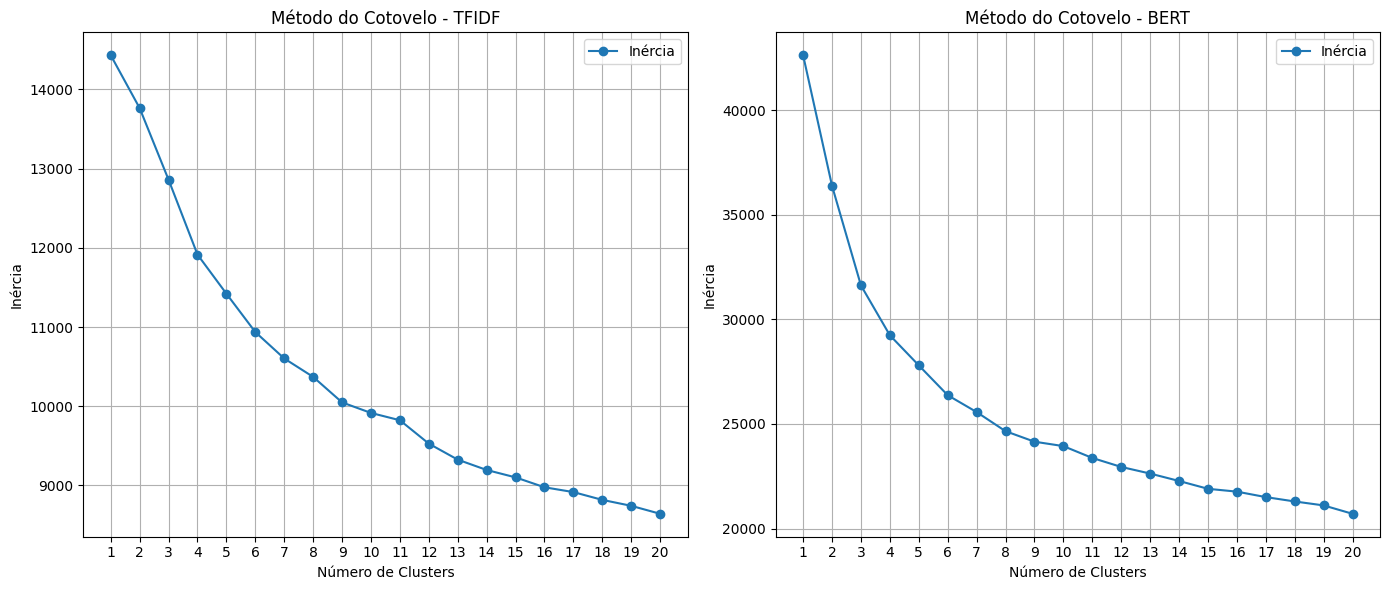

In [89]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def elbow_method(tfidf, bert, num_cluster_inicial=1, num_cluster_final=10):
    
    range_clusters = range(num_cluster_inicial, num_cluster_final + 1)
    inertia1 = []
    inertia2 = []

    # Calcula a inércia para cada número de clusters
    for k in range_clusters:
        kmeans1 = KMeans(n_clusters=k, random_state=42)
        kmeans1.fit(tfidf)
        inertia1.append(kmeans1.inertia_)
        
        kmeans2 = KMeans(n_clusters=k, random_state=42)
        kmeans2.fit(bert)
        inertia2.append(kmeans2.inertia_)

    # Plotando os resultados
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # TFIDF
    axes[0].plot(range_clusters, inertia1, marker='o', label='Inércia')
    axes[0].set_title("Método do Cotovelo - TFIDF")
    axes[0].set_xlabel("Número de Clusters")
    axes[0].set_ylabel("Inércia")
    axes[0].set_xticks(range_clusters)
    axes[0].grid(True)
    axes[0].legend()

    # BERT
    axes[1].plot(range_clusters, inertia2, marker='o', label='Inércia')
    axes[1].set_title("Método do Cotovelo - BERT")
    axes[1].set_xlabel("Número de Clusters")
    axes[1].set_ylabel("Inércia")
    axes[1].set_xticks(range_clusters)
    axes[1].grid(True)
    axes[1].legend()

    plt.tight_layout()
    plt.show()

elbow_method(X, embeddings, num_cluster_inicial=1, num_cluster_final=20)

## 5.2 - KMeans aplicado ao TFIDF e BERT

In [90]:
kmeans_tfidf = KMeans(n_clusters=20, random_state=42)
labels_tfidf = kmeans_tfidf.fit_predict(X)

kmeans_bert = KMeans(n_clusters=20, random_state=42)
labels_bert = kmeans_bert.fit_predict(embeddings)

In [91]:
clusters, counts = np.unique(labels_tfidf, return_counts=True)

for cluster, count in zip(clusters, counts):
    print(f'Cluster #{cluster}: {count} documentos')

Cluster #0: 1143 documentos
Cluster #1: 1194 documentos
Cluster #2: 1108 documentos
Cluster #3: 2009 documentos
Cluster #4: 274 documentos
Cluster #5: 444 documentos
Cluster #6: 721 documentos
Cluster #7: 258 documentos
Cluster #8: 561 documentos
Cluster #9: 1182 documentos
Cluster #10: 666 documentos
Cluster #11: 253 documentos
Cluster #12: 1470 documentos
Cluster #13: 556 documentos
Cluster #14: 1403 documentos
Cluster #15: 726 documentos
Cluster #16: 268 documentos
Cluster #17: 190 documentos
Cluster #18: 610 documentos
Cluster #19: 311 documentos


In [92]:
clusters, counts = np.unique(labels_bert, return_counts=True)

for cluster, count in zip(clusters, counts):
    print(f'Cluster #{cluster}: {count} documentos')

Cluster #0: 1043 documentos
Cluster #1: 1186 documentos
Cluster #2: 544 documentos
Cluster #3: 517 documentos
Cluster #4: 708 documentos
Cluster #5: 616 documentos
Cluster #6: 603 documentos
Cluster #7: 607 documentos
Cluster #8: 1113 documentos
Cluster #9: 376 documentos
Cluster #10: 1363 documentos
Cluster #11: 1017 documentos
Cluster #12: 273 documentos
Cluster #13: 1160 documentos
Cluster #14: 1139 documentos
Cluster #15: 686 documentos
Cluster #16: 460 documentos
Cluster #17: 952 documentos
Cluster #18: 944 documentos
Cluster #19: 40 documentos


## 5.3 - Palavras mais importantes por cluster

In [93]:
def palavras_importantes_por_cluster(textos, clusters, n=10):
    # Vetorização TF-IDF
    vectorizer = TfidfVectorizer(ngram_range=(1,3), max_features=5000)
    tfidf_matrix = vectorizer.fit_transform(textos)
    palavras = vectorizer.get_feature_names_out()
    
    # Armazena as palavras mais importantes por cluster
    palavras_por_cluster = {}

    # Itera por cluster único
    for cluster in set(clusters):
        # Seleciona os textos pertencentes ao cluster atual
        indices_cluster = [i for i, c in enumerate(clusters) if c == cluster]
        cluster_matrix = tfidf_matrix[indices_cluster]

        # Calcula a média dos pesos TF-IDF para cada palavra no cluster
        media_tfidf = cluster_matrix.mean(axis=0).A1  # Média ao longo dos documentos
        indices_importantes = media_tfidf.argsort()[::-1][:n]  # Seleção das palavras mais importantes

        # Adiciona as palavras mais importantes ao dicionário
        palavras_por_cluster[cluster] = [palavras[i] for i in indices_importantes]

    return palavras_por_cluster

### 5.3.1 - TFIDF

In [94]:
palavras_importantes_tfidf = palavras_importantes_por_cluster(textos=df['teorIntimacao_clean'].to_list(), clusters=labels_tfidf, n=20)

for key, value in palavras_importantes_tfidf.items():
    print(f'Cluster #{key}: {value}')

Cluster #0: ['cumprimento', 'cumprimento sentenca', 'sentenca', 'fazenda', 'calculos', 'juizado', 'exequente', 'despacho', 'obrigacao', 'permissao', 'com permissao', 'executada', 'fazer', 'juizado fazenda', 'com', 'ordinatorio com permissao', 'ordinatorio com', 'antiga', 'manifestacao', 'cojud']
Cluster #1: ['conformidade fazenda quinze', 'ordinatorio conformidade fazenda', 'conformidade fazenda', 'quinze certidao oficial', 'fazenda quinze certidao', 'quinze certidao', 'ordinatorio conformidade', 'certidao oficial', 'fazenda quinze', 'conformidade', 'certidao', 'oficial', 'exequente executado', 'ordinatorio', 'quinze', 'execucao fiscal', 'fiscal', 'executado', 'exequente', 'execucao']
Cluster #2: ['execucao fiscal', 'fiscal', 'execucao', 'execucao fiscal 1116', 'fiscal 1116', '1116', 'fiscal 1116 exequente', '1116 exequente', '1116 exequente executado', 'exequente', 'despacho', 'exequente executado', 'maia diogenes', 'tereza maia diogenes', 'executado', 'diogenes', 'requerer entender',

### 5.3.2 - BERT

In [95]:
palavras_importantes_bert = palavras_importantes_por_cluster(textos=df['teorIntimacao_clean'].to_list(), clusters=labels_bert, n=20)

for key, value in palavras_importantes_bert.items():
    print(f'Cluster #{key}: {value}')

Cluster #0: ['execucao fiscal', 'fiscal', 'execucao', 'execucao fiscal 1116', 'fiscal 1116', '1116', '1116 exequente', 'fiscal 1116 exequente', 'exequente', '1116 exequente executado', 'despacho', 'exequente executado', 'requerer entender', 'entender', 'requerer', 'executado', 'maia diogenes', 'tereza maia diogenes', 'diogenes', 'francisca tereza maia']
Cluster #1: ['sessao', 'virtual', 'videoconferencia', 'sessao videoconferencia', 'link', 'sessao ulterior tratar', 'reaprazado sessao ulterior', 'reaprazado sessao', 'reaprazado', 'orgao julgador colegiadonatal', 'automaticamente reaprazado', 'automaticamente reaprazado sessao', 'endereco httpplenariovirtualtjrnjusbr', 'verificar link ingresso', 'endereco httpplenariovirtualtjrnjusbr consultar', 'ingresso endereco httpplenariovirtualtjrnjusbr', 'verificar link', 'ulterior tratar sessao', 'ulterior tratar', 'colegiadonatal']
Cluster #2: ['recurso', 'inominado', 'sentenca', 'recurso inominado', 'voto', 'acordao', 'civel', 'municipal', 'ad

## 5.4 - Semelhança entre clusters

In [96]:
def similaridade_de_clusters(kmeans_instance, plot_title="Similaridade entre Clusters"):
    # Obtém os centróides dos clusters
    centroids = kmeans_instance.cluster_centers_

    # Calcula a similaridade cosseno entre os centróides
    similarity_matrix = cosine_similarity(centroids)

    # Organiza os resultados em um DataFrame para melhor visualização
    num_clusters = centroids.shape[0]
    similaridade_df = pd.DataFrame(
        similarity_matrix,
        index=[f"Cluster {i}" for i in range(num_clusters)],
        columns=[f"Cluster {i}" for i in range(num_clusters)]
    )

    # Plot do heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        similaridade_df,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        cbar=True,
        linewidths=0.5,
    )
    plt.title(plot_title)
    plt.show()

### 5.4.1 - TFIDF

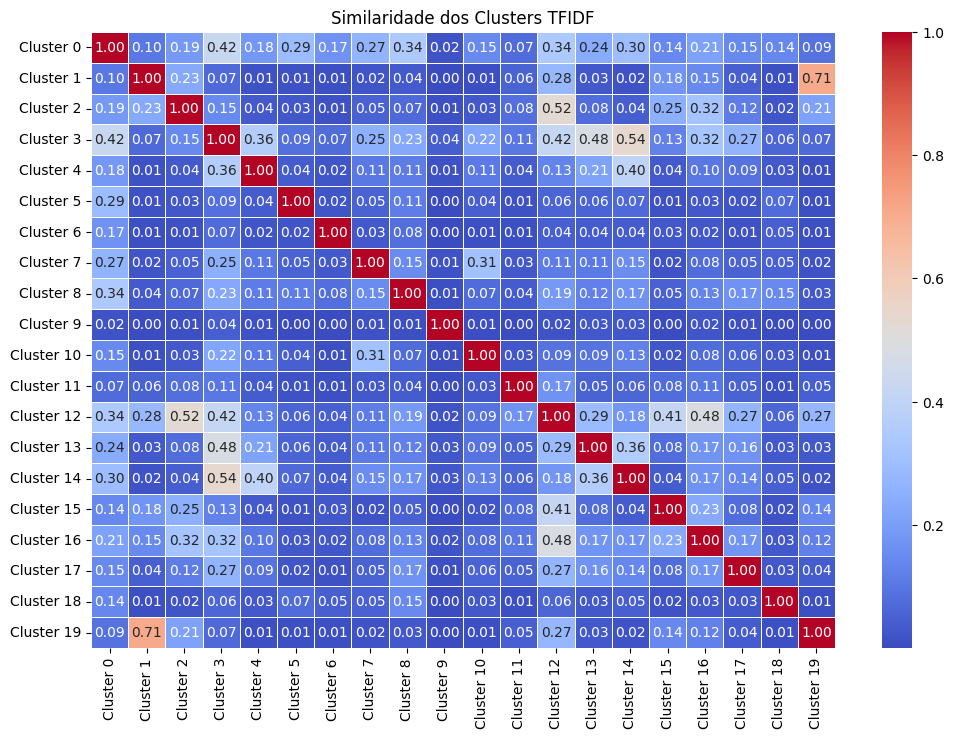

In [97]:
similaridade_de_clusters(kmeans_tfidf, plot_title='Similaridade dos Clusters TFIDF')

### 5.4.2 - BERT

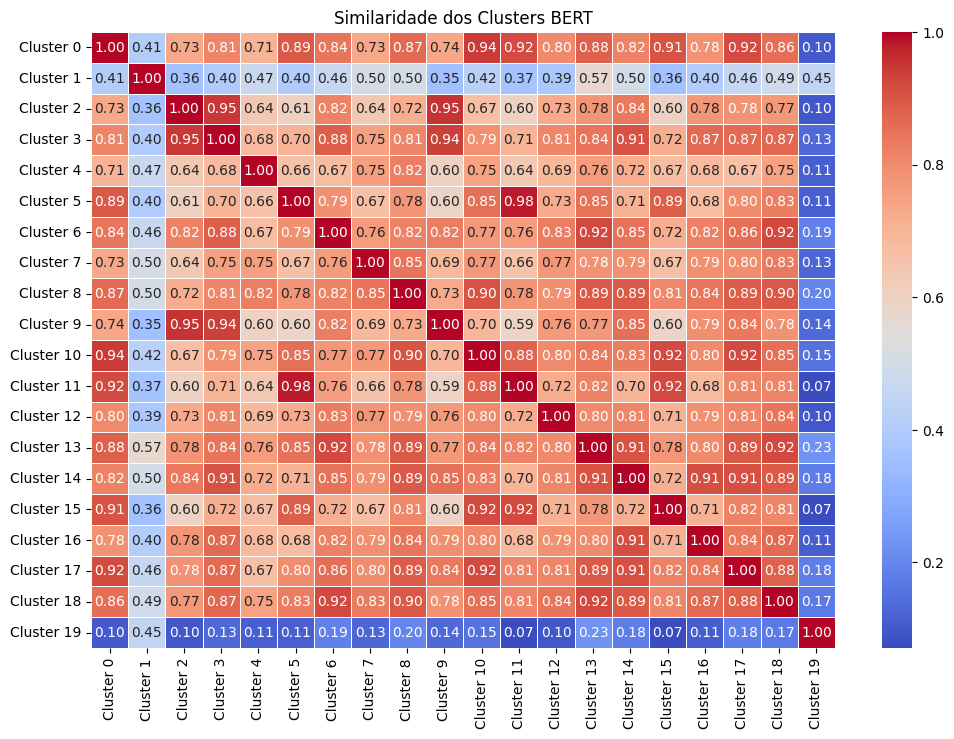

In [98]:
similaridade_de_clusters(kmeans_bert, plot_title='Similaridade dos Clusters BERT')